# Downscaled bioclimatic indicators

This dataset provides 76 bioclimatic indicators at a 1 x 1 km resolution for Europe, Northern Brazil, and Central Africa, reconstructed using ERA5 (ERA5-Land) reanalysis data and statistical downscaling. These indicators, focused on biodiversity and ecosystem services, include variables like surface energy, drought, soil moisture, wind, and Essential Climate Variables. Designed for the biodiversity community, the dataset supports diverse applications by offering temporal resolutions ranging from monthly to multi-annual averages.

**Information on Dataset:**
* Source: [Downscaled Bioclimatic Indicators](https://cds.climate.copernicus.eu/datasets/sis-biodiversity-era5-regional?tab=overview)
* Author:
* Notebook Version: 1.1 (Updated: January 21, 2025)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Specify Directories Here ---- '''
download_folder = r".\data\sis-biodiversity-era5-regional\download"
working_folder = r".\data\sis-biodiversity-era5-regional\working"
geotiff_folder = r".\data\sis-biodiversity-era5-regional\geotiff"
csv_folder = r".\data\sis-biodiversity-era5-regional\csv"
output_folder = r".\data\sis-biodiversity-era5-regional\output"
''' ----- End of Declaration ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract the Dataset

### 2.1 Authentication

In [2]:
import cdsapi

def main():
    # API key for authentication
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Creation of the CDS API client
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Define the "request" and Download the Dataset

In [3]:
# Define additional request fields to ensure the request stays within the file size limit.
# These coordinates were obtained using the BBox Extractor tool:
# https://str-ucture.github.io/bbox-extractor/

bbox_wgs84_deutschland = [56.0, 5.8, 47.2, 15.0]
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]

# Alternatively, use a shapefile for precise geographic filtering
import geopandas as gpd
import math

# Example: Load shapefile of Konstanz (WGS84 projection)
de_shapefile = r"./shapefiles/de_boundary.shp"
de_gdf = gpd.read_file(de_shapefile)
de_bounds = de_gdf.total_bounds

# Adjust and buffer
de_bounds_adjusted = [(math.floor(de_bounds[0]* 10)/10)-0.1,
                      (math.floor(de_bounds[1]* 10)/10)-0.1,
                      (math.ceil(de_bounds[2]* 10)/10)+0.1,
                      (math.ceil(de_bounds[3]* 10)/10)+0.1]

bbox_de_bounds_adjusted = [de_bounds_adjusted[3], de_bounds_adjusted[0],
                           de_bounds_adjusted[1], de_bounds_adjusted[2]]

In [4]:
## Currently for Region == Europe, only ERA5 is available
# for Region == Central Africa, ERA5 is available
# for Region == Northern Brazil, ERA5-Land is available

## Variable group: Bioclimatic indicators as in WORLDCLIM
# cds.climate.copernicus.eu/datasets/sis-biodiversity-era5-regional?tab=download
variable_group = "bioclimatic_indicators_as_in_worldclim"

In [5]:
dataset = "sis-biodiversity-era5-regional"
request = {
    "region": ["europe"],
    "origin": "era5",
    "variable": [
        "annual_mean_temperature",
        "mean_diurnal_range",
        "isothermality",
        "temperature_seasonality",
        "maximum_temperature_of_warmest_month",
        "minimum_temperature_of_coldest_month",
        "temperature_annual_range",
        "mean_temperature_of_wettest_quarter",
        "mean_temperature_of_driest_quarter",
        "mean_temperature_of_warmest_quarter",
        "mean_temperature_of_coldest_quarter",
        "annual_precipitation",
        "precipitation_of_wettest_month",
        "precipitation_of_driest_month",
        "precipitation_seasonality",
        "precipitation_of_wettest_quarter",
        "precipitation_of_driest_quarter",
        "precipitation_of_warmest_quarter",
        "precipitation_of_coldest_quarter"
    ],
    "statistic": [
        "mean",
        "median",
        "25th_quartile",
        "75th_quartile"
    ],
    "version": ["1_0"]
}

In [6]:
# Execute it to download the dataset:
def main_retrieve():
    dataset_filename = f"{dataset}_{variable_group}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Download the dataset only if the dataset has not been downloaded before
    if not os.path.isfile(dataset_filepath):
        # Download the dataset with the defined request parameters
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Dataset already downloaded.")

if __name__ == "__main__":
    client = main()
    main_retrieve()

2025-02-24 12:13:30,995 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2025-02-24 12:13:30,997 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


Dataset already downloaded.


### 2.3 Extract the Zip Folder(s)

In [7]:
import zipfile

# Create the folder path to extract Zip file(s) based on the variable group
extract_folder = os.path.join(working_folder, variable_group)
os.makedirs(extract_folder, exist_ok=True)

# Extract the ZIP file
try:
    if not os.listdir(extract_folder):
        dataset_filename = f"{dataset}_{variable_group}.zip"
        dataset_filepath = os.path.join(download_folder, dataset_filename)
        
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. Read the netCDF4 file and print the Metadata

### 3.1 Create a Dataframe of Available netCDF Files

In [8]:
import re
import pandas as pd
import netCDF4 as nc
import numpy as np

def meta(filename):
    # Match the filename against the expected pattern
    match = re.search(
        r"(?P<ds_variable>BIO\d{2})_(?P<ds_origin>[\w-]+)-(?P<statistic>mean|median|q25|q75)_v(?P<version>\d+\.\d+)",
        filename
        )
    if not match:
        raise ValueError("the given filename does not fit the expected naming scheme")
    
    file_path = os.path.join(extract_folder, filename)
    
    # Extract primary variable and its shape from the NetCDF file
    def get_nc_variable():
        with nc.Dataset(file_path, 'r') as nc_dataset:
            variable_names = list(nc_dataset.variables.keys())

            primary_variable_index = 3  # Adjust this index as needed
            if primary_variable_index >= len(variable_names):
                raise IndexError("Primary variable index is out of range for the NetCDF variables.")
            
            primary_variable = variable_names[primary_variable_index]
            primary_variable_shape = np.shape(nc_dataset[primary_variable])

            return primary_variable, primary_variable_shape
    
    # Return metadata as a dictionary
    return dict(
        filename=filename,
        path=os.path.join(extract_folder, filename),
        ds_variable=match.group('ds_variable'),
        ds_origin=match.group('ds_origin'),
        variable_name=get_nc_variable()[0],
        variable_shape=get_nc_variable()[1],
        statistic=match.group('statistic')
    )

# Extract metadata for all NetCDF files in the folder
nc_files = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.nc')]
df_nc_files = pd.DataFrame.from_dict(nc_files)

# Modify pandas display options
pd.options.display.max_colwidth = 30

# Display the DataFrame without displaying the 'path' column
df_nc_files.loc[:, df_nc_files.columns != 'path']

,filename,ds_variable,ds_origin,variable_name,variable_shape,statistic
0,BIO01_era5-to-1km_1979-201...,BIO01,era5-to-1km_1979-2018,BIO01,"(1, 4800, 9600)",mean
1,BIO01_era5-to-1km_1979-201...,BIO01,era5-to-1km_1979-2018,BIO01,"(1, 4800, 9600)",median
2,BIO01_era5-to-1km_1979-201...,BIO01,era5-to-1km_1979-2018,BIO01,"(1, 4800, 9600)",q25
3,BIO01_era5-to-1km_1979-201...,BIO01,era5-to-1km_1979-2018,BIO01,"(1, 4800, 9600)",q75
4,BIO02_era5-to-1km_1979-201...,BIO02,era5-to-1km_1979-2018,BIO02,"(1, 4800, 9600)",mean
...,...,...,...,...,...,...
71,BIO18_era5-to-1km_1979-201...,BIO18,era5-to-1km_1979-2018,BIO18,"(1, 4800, 9600)",q75
72,BIO19_era5-to-1km_1979-201...,BIO19,era5-to-1km_1979-2018,BIO19,"(1, 4800, 9600)",mean
73,BIO19_era5-to-1km_1979-201...,BIO19,era5-to-1km_1979-2018,BIO19,"(1, 4800, 9600)",median
74,BIO19_era5-to-1km_1979-201...,BIO19,era5-to-1km_1979-2018,BIO19,"(1, 4800, 9600)",q25


### 3.2 Print unique Variable name(s) and Available Variables

In [9]:
# Keep track of processed variable names to avoid duplicates
seen_variables = set()

# List all variables in each NetCDF file
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Skip if the variable has already been processed
    if variable_name in seen_variables:
        continue

    # Open the NetCDF file in read 
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:
        # List all variables in the current dataset
        variables_list = list(nc_dataset.variables.keys())
        
        # Print details of the file and its variables
        print(f"{i + 1:<2} {variable_name:<8}: Available variables: {variables_list}")
    
    # Mark this variable as seen
    seen_variables.add(variable_name)

1  BIO01   : Available variables: ['latitude', 'longitude', 'time', 'BIO01']
5  BIO02   : Available variables: ['latitude', 'longitude', 'time', 'BIO02']
9  BIO03   : Available variables: ['latitude', 'longitude', 'time', 'BIO03']
13 BIO04   : Available variables: ['latitude', 'longitude', 'time', 'BIO04']
17 BIO05   : Available variables: ['latitude', 'longitude', 'time', 'BIO05']
21 BIO06   : Available variables: ['latitude', 'longitude', 'time', 'BIO06']
25 BIO07   : Available variables: ['latitude', 'longitude', 'time', 'BIO07']
29 BIO08   : Available variables: ['latitude', 'longitude', 'time', 'BIO08']
33 BIO09   : Available variables: ['latitude', 'longitude', 'time', 'BIO09']
37 BIO10   : Available variables: ['latitude', 'longitude', 'time', 'BIO10']
41 BIO11   : Available variables: ['latitude', 'longitude', 'time', 'BIO11']
45 BIO12   : Available variables: ['latitude', 'longitude', 'time', 'BIO12']
49 BIO13   : Available variables: ['latitude', 'longitude', 'time', 'BIO13']

In [10]:
# Extract information from the first NetCDF file
nc_file = nc_files[0]

# Open the NetCDF file in read mode
with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:
    # Retrieve a list of all variable names in the dataset
    variables_list = list(nc_dataset.variables.keys())
    
    # Initialize a list to hold the rows of the DataFrame
    rows = []

    # Loop through all variables in the dataset
    for test_var in variables_list:
        try:
            # Get the variable object
            var_obj = nc_dataset.variables[test_var]
            
            # Extract attributes: units (default to 'N/A' if not present) and shape
            unit = getattr(var_obj, 'units', 'N/A')
            shape = var_obj.shape
            
            # Append the extracted details to the rows list
            rows.append({
                "nc_variables": test_var,
                "unit": unit,
                "shape": shape
            })
        except Exception as e:
            # Handle any errors and continue processing other variables
            print(f"Error processing variable '{test_var}': {e}")

# Create a DataFrame from the rows
df = pd.DataFrame(rows)

# Display the DataFrame
df

,nc_variables,unit,shape
0,latitude,degrees_north,"(4800,)"
1,longitude,degrees_east,"(9600,)"
2,time,days since 1999-01-01,"(1,)"
3,BIO01,K,"(1, 4800, 9600)"


In [11]:
seen_variables = set()

# Loop through all NetCDF files to extract information about variables
for index, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Skip already processed variables
    if variable_name in seen_variables:
        continue
    
    # Open the NetCDF file in read mode
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:
        # Access the primary variable data
        variable_data = nc_dataset[variable_name]
        
        # Generate a summary of the primary variable
        summary = {
            "Variable Name": variable_name,
            "Data Type": variable_data.dtype,
            "Shape": variable_data.shape,
            "Variable Info (Dimensions)": f"{variable_data.dimensions}",
            "Units": getattr(variable_data, "units", "N/A"),
            "Long Name": getattr(variable_data, "long_name", "N/A"),
        }
        
        # Display dataset summary as a DataFrame for better visualization
        nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])
        print(f"{index + 1}. Summary of Variable '{variable_name}':")
        display(nc_summary)
    
    # Add the variable name to the seen set
    seen_variables.add(variable_name)
    
    # Limit output
    output_limit = 2
    if len(seen_variables) >= output_limit:
        print(f".... (Output truncated to first {output_limit} variables)")
        break

1. Summary of Variable 'BIO01':


,Description,Remarks
0,Variable Name,BIO01
1,Data Type,float32
2,Shape,"(1, 4800, 9600)"
3,Variable Info (Dimensions),"('time', 'latitude', 'long..."
4,Units,K
5,Long Name,Temperature annual mean


5. Summary of Variable 'BIO02':


,Description,Remarks
0,Variable Name,BIO02
1,Data Type,float32
2,Shape,"(1, 4800, 9600)"
3,Variable Info (Dimensions),"('time', 'latitude', 'long..."
4,Units,K
5,Long Name,Mean diurnal range (mean o...


.... (Output truncated to first 2 variables)


## 4. Export Dataset to CSV

⚠️ <span style="background-color: red; color: white; padding: 2px 4px;">Important</span>: After downloading the datasets, please ensure to select the correct variable name from the appropriate variable group. For example, if you’re interested in the annual mean temperature, choose the variable **BIO01** which is equivalent to **Annual mean temperature (BIO01)**.

In [12]:
# Modify the selected variable here
selected_variable = "BIO01" # Set the variable of interest (e.g., BIO01 for Annual Mean Temperature)

# Filter the NetCDF files based on the selected variable
selected_nc_files = [nc_file for nc_file in nc_files if nc_file['ds_variable'] == selected_variable]

### 4.1 Define a function to convert NetCDF data to a pandas DataFrame

In [13]:
import xarray as xr

# Function to convert NetCDF data to a pandas DataFrame
def netcdf_to_dataframe(nc_file, bounding_box=None):
    """
    Convert the variable data from a NetCDF file to a pandas DataFrame.
    
    Args:
        nc_file (dict): A dictionary containing metadata for the NetCDF file, including 'path' and 'variable_name'.
        bounding_box (tuple, optional): A tuple of the form (min_lon, min_lat, max_lon, max_lat) to filter the data by geographic bounds.

    Returns:
        pd.DataFrame: A pandas DataFrame with the filtered data.
    """
    with xr.open_dataset(nc_file['path']) as nc_dataset:
        # Access the variable data from the datase
        variable_data = nc_dataset[nc_file['variable_name']]
        
        # Ensure latitude and longitude names are correct
        latitude_name = 'latitude' if 'latitude' in nc_dataset.coords else 'lat'
        longitude_name = 'longitude' if 'longitude' in nc_dataset.coords else 'lon'
        
        # Filter the data based on the bounding box, if provided
        if bounding_box:
            filtered_data = variable_data.where(
                (nc_dataset[latitude_name] >= bounding_box[1]) & (nc_dataset[latitude_name] <= bounding_box[3]) &
                (nc_dataset[longitude_name] >= bounding_box[0]) & (nc_dataset[longitude_name] <= bounding_box[2]),
                drop=True
            )
        else:
            filtered_data = variable_data

        # Convert the xarray dataset to a pandas DataFrame
        df = filtered_data.to_dataframe().reset_index().set_index(['time', latitude_name, longitude_name])
        
        # Rename the value column to use the filename as the column name (optional)
        df.rename(columns={nc_file['variable_name']: nc_file['filename']}, inplace=True)
        
        return df

### 4.2 Filter by Bounding Box, Create DataFrame and Export as merged CSV file

In [14]:
# Define additional request fields to ensure the request stays within the file size limit.
# These coordinates were obtained using the BBox Extractor tool:
# https://str-ucture.github.io/bbox-extractor/

# Bounding Box for Konstanz (in WGS84 coordinate system: [North, West, South, East])
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]

# Bounding Box for Konstanz (in standard format: [West, South, East, North])
bbox_wgs84_konstanz_standard = [8.9, 47.6, 9.3, 47.9]

# Bounding Box for Germany (in standard format: [West, South, East, North])
bbox_wgs84_de_standard = [5.7, 47.1, 15.2, 55.2]

In [15]:
from tqdm.notebook import tqdm
import textwrap

# Create a folder for the subset CSV files based on the variable group
subset_csv_folder = os.path.join(csv_folder, variable_group)
os.makedirs(subset_csv_folder, exist_ok=True)

# Define the path for the subset CSV file
subset_csv_filename = f"{selected_variable}.csv.zip"
subset_csv_path = os.path.join(subset_csv_folder, subset_csv_filename)

# Create a DataFrame and create a CSV file if it doesn't already exists
if not os.path.isfile(subset_csv_path):
    # Process NetCDF files into dataframes and merge them
    dataframes = [netcdf_to_dataframe(nc_file=nc_file, bounding_box=bbox_wgs84_de_standard) for nc_file in tqdm(selected_nc_files)]
    df_merged = pd.concat(dataframes, axis=1)

    # Export the merged dataframe to a compressed CSV file
    df_merged.to_csv(subset_csv_path, sep=',', encoding='utf8', compression='zip')
else:
    print(f"File already exists at {subset_csv_path}. Skipping export.")
    print("Reading existing CSV file...")

    # Read the existing CSV file into a DataFrame
    df_merged = pd.read_csv(subset_csv_path).set_index(['time', 'latitude', 'longitude'])

# Function to wrap long column names in the DataFrame for better readability
def wrap_column_names(df, width):
    wrapped_columns = {col: " ".join(textwrap.wrap(col, width)) for col in df.columns}
    return df.rename(columns=wrapped_columns)
    
# Modify pandas display options to format floats
pd.options.display.float_format = '{:,.2f}'.format
    
# Display the DataFrame
df_wrapped = wrap_column_names(df_merged, width=12)
df_wrapped

File already exists at .\data\sis-biodiversity-era5-regional\csv\bioclimatic_indicators_as_in_worldclim\BIO01.csv.zip. Skipping export.
Reading existing CSV file...


BIO01_era5- to-1km_1979- 2018- mean_v1.0.nc  \
time       latitude longitude                                                
1999-01-01 47.10    5.70                              284.57                 
                    5.71                              284.57                 
                    5.72                              284.55                 
                    5.73                              284.54                 
                    5.74                              284.51                 
...                                                      ...                 
           55.20    15.16                             281.95                 
                    15.17                             281.94                 
                    15.18                             281.93                 
                    15.19                             281.93                 
                    15.20                             281.92                 

                               BIO01_era5- to-1km_1979- 2018- median_v1.0. nc  \
time       latitude longitude                                                   
1999-01-01 47.10    5.70                              284.59                    
                    5.71                              284.59                    
                    5.72                              284.57                    
                    5.73                              284.57                    
                    5.74                              284.54                    
...                                                      ...                    
           55.20    15.16                             282.07                    
                    15.17                             282.07                    
                    15.18                             282.06                    
                    15.19                             282.05                    
                    15.20                             282.05                    

                               BIO01_era5- to-1km_1979- 2018- q25_v1.0.nc  \
time       latitude longitude                                               
1999-01-01 47.10    5.70                              284.02                
                    5.71                              284.02                
                    5.72                              284.00                
                    5.73                              283.99                
                    5.74                              283.97                
...                                                      ...                
           55.20    15.16                             281.51                
                    15.17                             281.51                
                    15.18                             281.50                
                    15.19                             281.49                
                    15.20                             281.49                

                               BIO01_era5- to-1km_1979- 2018- q75_v1.0.nc  
time       latitude longitude                                              
1999-01-01 47.10    5.70                              285.10               
                    5.71                              285.10               
                    5.72                              285.08               
                    5.73                              285.07               
                    5.74                              285.05               
...                                                      ...               
           55.20    15.16                             282.72               
                    15.17                             282.71               
                    15.18                             282.70               
                    15.19                             282.70               
                    15.20                       

## 5. Export Dataset to GeoTIFF

In [16]:
import numpy as np
from rasterio.transform import from_origin
import rasterio

from tqdm.notebook import tqdm

def main_export_geotiff(
    nc_file,
    bounding_box=None,
    start_year=None,
    end_year=None,
    merged=None,
    output_directory=None):
    
    """
    Export the entire multi-year dataset or a specified range as a single merged GeoTIFF file.

    Parameters:
        nc_file (dict): A dictionary with keys 'path' (file path), 'variable', 'rcp', and 'statistic'.
        bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
        start_year (int): Starting year for the dataset (optional).
        end_year (int): Ending year for the dataset (optional).
        merged (bool): Whether to generate merged GeoTIFF or individual GeoTIFFs (optional).
        output_directory (str): Directory to save the output GeoTIFF files (optional).
    """
    
    # Open the netCDF file
    with nc.Dataset(nc_file['path'], 'r') as nc_dataset:
        nc_dataset = nc.Dataset(nc_file['path'], 'r')
        
        lon = nc_dataset['longitude'][:]
        lat = nc_dataset['latitude'][:]
        
        # Filter by bounding box if provided
        if bounding_box:
            lon_min, lat_min, lon_max, lat_max = bounding_box
            
            indices_lat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
            indices_lon = np.where((lon >= lon_min) & (lon <= lon_max))[0]
            start_lat, end_lat = indices_lat[0], indices_lat[-1] + 1
            start_lon, end_lon = indices_lon[0], indices_lon[-1] + 1
        else:
            start_lat, end_lat = 0, len(lat)
            start_lon, end_lon = 0, len(lon)
        
        lat = lat[start_lat:end_lat]
        lon = lon[start_lon:end_lon]
            
        # Extract time variable and convert it to readable dates
        time_var = nc_dataset.variables['time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
        
        # Compute spatial resolution and raster transformation
        dx = abs(lon[1] - lon[0])
        dy = abs(lat[1] - lat[0])
        transform = from_origin(lon.min() - dx / 2, lat.min() - dy / 2, dx, -dy)
            
        # Determine the time range
        min_year = cftime[0].year
        max_year = cftime[-1].year

        if start_year and end_year:
            # Adjust start_year and end_year based on the available cftime range
            if start_year < min_year:
                print(f"Provided start year {start_year} is earlier than the dataset range. Adjusting start year to {min_year}.")
            if end_year > max_year:
                print(f"Provided end year {end_year} is later than the dataset range. Adjusting end year to {max_year}.")
            start_year = max(start_year, min_year)
            end_year = min(end_year, max_year)

            dt_full_start = start_year
            dt_full_end = end_year
        else:
            # Default to the full dataset
            dt_full_start = min_year
            dt_full_end = max_year
            start_year = min_year
            end_year = max_year
            
        # Find indices corresponding to the specified year range
        start_index = next(i for i, dt in enumerate(cftime) if dt.year == start_year)
        end_index = next(i for i, dt in enumerate(cftime) if dt.year == end_year) + 1 # Year
        
        # Extract temperature/variable data
        variable_data = nc_dataset.variables[nc_file['variable_name']]
        variable_data_subset = variable_data[start_index:end_index,
                                            start_lat:end_lat,
                                            start_lon:end_lon]
        
        # Create subset directory name based on the nc_file
        nc_filename = f"{nc_files[0]['variable_name']}-subset.csv.zip"

        if merged:
            # Create a merged GeoTIFF containing all time slices as separate bands
            if output_directory:
                subset_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{selected_variable}-merged")
                os.makedirs(subset_directory_path, exist_ok=True)

            output_filename = f"{nc_file['variable_name']}_{nc_file['statistic']}.tif"
            output_filepath = os.path.join(subset_directory_path, output_filename)

            # Create a GeoTIFF with multiple bands for each time slice
            with rasterio.open(
                output_filepath,
                "w",
                driver = "GTiff",
                dtype = str(variable_data_subset.dtype),
                width = variable_data_subset.shape[2],
                height = variable_data_subset.shape[1],
                count = variable_data_subset.shape[0],
                crs = "EPSG:4326",
                nodata = -9999,
                transform=transform,        
            ) as dst:
                for year_index in tqdm(range(variable_data_subset.shape[0]),
                                    desc=f"Exporting merged GeoTIFF file from {start_year} to {end_year}"):
                    band_data = variable_data_subset[year_index,:,:]
                    dt = cftime[start_index + year_index]
                    band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                    
                    # Write each year slice as a band
                    dst.write(band_data, year_index + 1)
                    dst.set_band_description(year_index + 1, band_desc)
                    
        else:
            if output_directory:
                subset_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{selected_variable}-individual")
                os.makedirs(subset_directory_path, exist_ok=True)
            
            for year_index in tqdm(range(variable_data_subset.shape[0]),
                                desc="Exporting individual GeoTIFF files"):
                # Retrieve the date for the current time slice
                dt = cftime[start_index + year_index]
                dt_full = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

                # Define the output GeoTIFF file path            
                output_filename = f"{nc_filename}_{dt_full}.tif"
                output_filepath = os.path.join(subset_directory_path, output_filename)

                # Export the current time slice as a GeoTIFF
                with rasterio.open(
                    output_filepath,
                    "w",
                    driver="GTiff",
                    dtype=str(variable_data_subset.dtype),
                    width=variable_data_subset.shape[2],
                    height=variable_data_subset.shape[1],
                    count=1,
                    crs="EPSG:4326",
                    nodata=-9999,
                    transform=transform,
                ) as dst:
                    year_precipitation_data = variable_data_subset[year_index, :, :]
                    dst.write(year_precipitation_data, 1)
                    dst.set_band_description(1, f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}")

In [17]:
# Specify the year range to filter and combine data into a single GeoTIFF.
# If no range is provided, the full dataset will be used.
# If same start and end year is used for export, then old GeoTIFF file will be replaced.

if __name__ == "__main__":
    # Export all merged for Germany
    for nc_file in selected_nc_files:
        main_export_geotiff(nc_file=nc_file,
                            bounding_box=bbox_wgs84_de_standard,
                            merged=True) # Merged GeoTIFF
    # # Export all merged for Konstanz
    # for nc_file in selected_nc_files:
    #     main_export_geotiff(nc_file=nc_file,
    #                         bounding_box=bbox_wgs84_konstanz_standard,
    #                         merged=True) # Merged GeoTIFF

Exporting merged GeoTIFF file from 1999 to 1999:   0%|          | 0/1 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1999 to 1999:   0%|          | 0/1 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1999 to 1999:   0%|          | 0/1 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1999 to 1999:   0%|          | 0/1 [00:00<?, ?it/s]

## 6. Plot using Matplotlib

### 6.1 Plot the Complete data

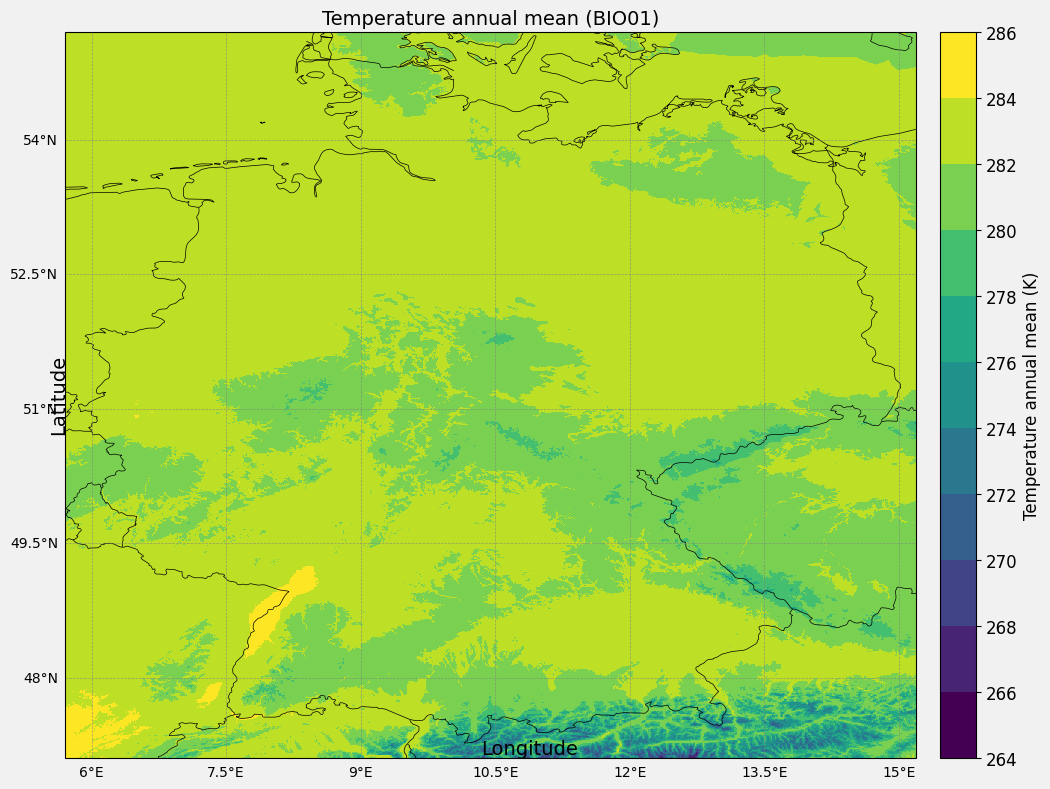

In [18]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np
import netCDF4 as nc

# Variables and inputs
nc_file = selected_nc_files[0]
bounding_box = bbox_wgs84_de_standard

def main_plt_plot(nc_file, bounding_box=None):
    # Open the NetCDF dataset
    nc_dataset = nc.Dataset(nc_file['path'], mode='r')

    # Access latitude and longitude variables
    latitudes = nc_dataset.variables['latitude'][:]
    longitudes = nc_dataset.variables['longitude'][:]

    # Find indices for the bounding box
    lat_indices = np.where((latitudes >= bounding_box[1]) & (latitudes <= bounding_box[3]))[0]
    lon_indices = np.where((longitudes >= bounding_box[0]) & (longitudes <= bounding_box[2]))[0]

    # Subset latitude and longitude
    lat_subset = latitudes[lat_indices]
    lon_subset = longitudes[lon_indices]

    # Extract variable data
    variable_name = nc_file['variable_name']
    variable_data = nc_dataset.variables[variable_name][..., lat_indices, lon_indices]
    
    var_longname = getattr(nc_dataset.variables[variable_name], "long_name", "N/A")
    var_units = getattr(nc_dataset.variables[variable_name], "units", "N/A")

    # Calculate vmin, vmax, and bins
    interval = 2
    vmin = np.floor(np.nanmin(variable_data) / interval) * interval
    vmax = np.ceil(np.nanmax(variable_data) / interval) * interval
    bins = int((vmax - vmin) / interval)

    # Create a 2D grid for plotting
    lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)

    # Create the plot
    fig, ax = plt.subplots(
        figsize=(12, 8),
        facecolor='#f1f1f1',
        edgecolor='k',
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Add map features
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)

    # Create a colormesh plot
    cmap = plt.get_cmap("viridis", bins)
    pcm = ax.pcolormesh(
        lon_grid, lat_grid, variable_data[0, :, :],
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        shading='auto',
        vmin=vmin,
        vmax=vmax
    )

    # Adjust map extent to match data
    ax.set_extent([lon_subset.min(), lon_subset.max(), lat_subset.min(), lat_subset.max()], crs=ccrs.PlateCarree())

    # Add a colorbar
    ticks = np.linspace(vmin, vmax, num=bins + 1)
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, ticks=ticks)
    cbar.set_label(f"{var_longname} ({var_units})", fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    
    # Add grid lines
    gl = ax.gridlines(draw_labels=True,
                      crs=ccrs.PlateCarree(),
                      linewidth=0.5,
                      color='gray',
                      alpha=0.7,
                      linestyle='--')
    gl.top_labels = False 
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    # Add title and labels
    fig.text(0.5, 0.05, 'Longitude', ha='center', fontsize=14)
    fig.text(0.1, 0.5, 'Latitude', va='center', rotation='vertical', fontsize=14)
    ax.set_aspect("equal")

    # Add a title
    ax.set_title(f"{var_longname} ({variable_name})", fontsize=14)

    # Save or display the plot
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    

if __name__ == "__main__":
    # Example usage
    main_plt_plot(nc_file=selected_nc_files[0], bounding_box=bbox_wgs84_de_standard)